<a href="https://colab.research.google.com/github/vchandraiitk/PokerCardGame/blob/master/Vikas_M8_NB_MiniProject_4_AirQuality_Forecast_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Air quality forecasting using ARIMA

## Learning Objectives

At the end of the experiment, you will be able to :

* perform EDA on time series data
* analyze the auto correlation and partial auto correlation plots
* implement the ARIMA model and forecast the air quality

## Information

ARIMA stands for auto-regressive integrated moving average. It’s a way of modelling time series data for forecasting (i.e., for predicting future points in the series), in such a way that:

* a pattern of growth/decline in the data is accounted for (“auto-regressive” part)
* the rate of change of the growth/decline in the data is accounted for (the “integrated” part)
* noise between consecutive time points is accounted for (the “moving average” part)

ARIMA models are typically expressed like “ARIMA(p,d,q)”, with the three terms p, d, and q defined as follows:

* p means the number of preceding (“lagged”) Y values that have to be added/subtracted to Y in the model, so as to make better predictions based on local periods of growth/decline in our data. This captures the “autoregressive” nature of ARIMA.

* d represents the number of times that the data have to be “differenced” to produce a stationary signal (i.e., a signal that has a constant mean over time). This captures the “integrated” nature of ARIMA. If d=0, this means that our data does not tend to go up/down in the long term (i.e., the model is already “stationary”). In this case, then technically you are performing just ARMA, not AR-I-MA. If p is 1, then it means that the data is going up/down linearly. If p is 2, then it means that the data is going up/down exponentially. More on this below…

* q represents the number of preceding/lagged values for the error term that are added/subtracted to Y. This captures the “moving average” part of ARIMA.



Refer to the basics of Air quality index [here](https://www.airnow.gov/aqi/aqi-basics/)

## Dataset



This dataset includes hourly air pollutants data from 12 nationally-controlled air-quality monitoring sites. The air-quality data are from the Beijing Municipal Environmental Monitoring Center. The meteorological data in each air-quality site are matched with the nearest weather station from the China Meteorological Administration. The time period is from March 1st, 2013 to February 28th, 2017. Missing data are denoted as NA.

**Attributes Information:**

* No: row number
* year: year of data in this row
* month: month of data in this row
* day: day of data in this row
* hour: hour of data in this row
* PM2.5: PM2.5 concentration (ug/m^3)

  Fine particulate matter (PM2.5) is an air pollutant that is a concern for people's health when levels in air are high. PM2.5 are tiny particles in the air that reduce visibility and cause the air to appear hazy when levels are elevated

* PM10: PM10 concentration (ug/m^3)
* SO2: SO2 concentration (ug/m^3)
* NO2: NO2 concentration (ug/m^3)
* CO: CO concentration (ug/m^3)
* O3: O3 concentration (ug/m^3)
* TEMP: temperature (degree Celsius)
* PRES: pressure (hPa)
* DEWP: dew point temperature (degree Celsius)
* RAIN: precipitation (mm)
* wd: wind direction
* WSPM: wind speed (m/s)
* station: name of the air-quality monitoring site

**Dataset source:** https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data

## Problem Statement

Implement ARIMA model to forecast the air quality using Beijing air quality dataset

## Grading = 10 Points

In [ ]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/PRSA_Data_Nongzhanguan_20130301_20170228.csv
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


### Import required Packages

In [ ]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import expit, logit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import itertools

### Load the data and analyze (2 Points)

Refer to casestudy: [M6_NB_Case_Study_EDA_Air_Quality_Data](https://drive.google.com/file/d/1BL6vbcSH9HEhH20zvnABTjoSaZ-a4olg/view?usp=drive_link)

In [ ]:
path = "PRSA_Data_Nongzhanguan_20130301_20170228.csv"
# YOUR CODE HERE
df = pd.read_csv(path)
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('date', inplace=True)

### Correlation plot between Features (1 Point)

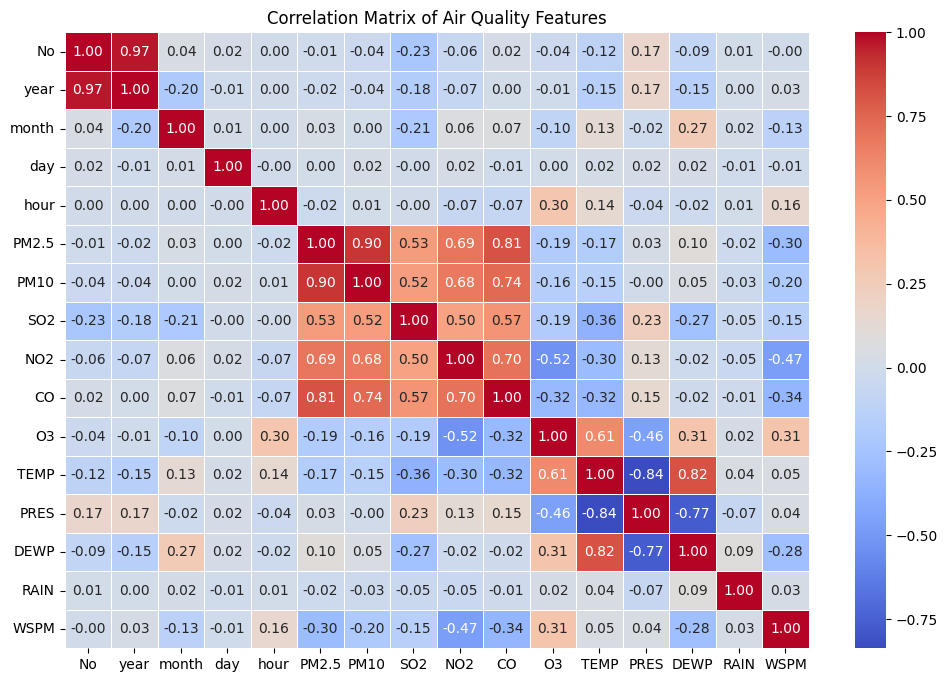

In [ ]:
# YOUR CODE HERE
corr = df.select_dtypes(include=np.number).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Air Quality Features")
plt.show()

### Identify the trends and seasonality from the given time series data (1 Point)

Hint: `seasonal_decompose()`

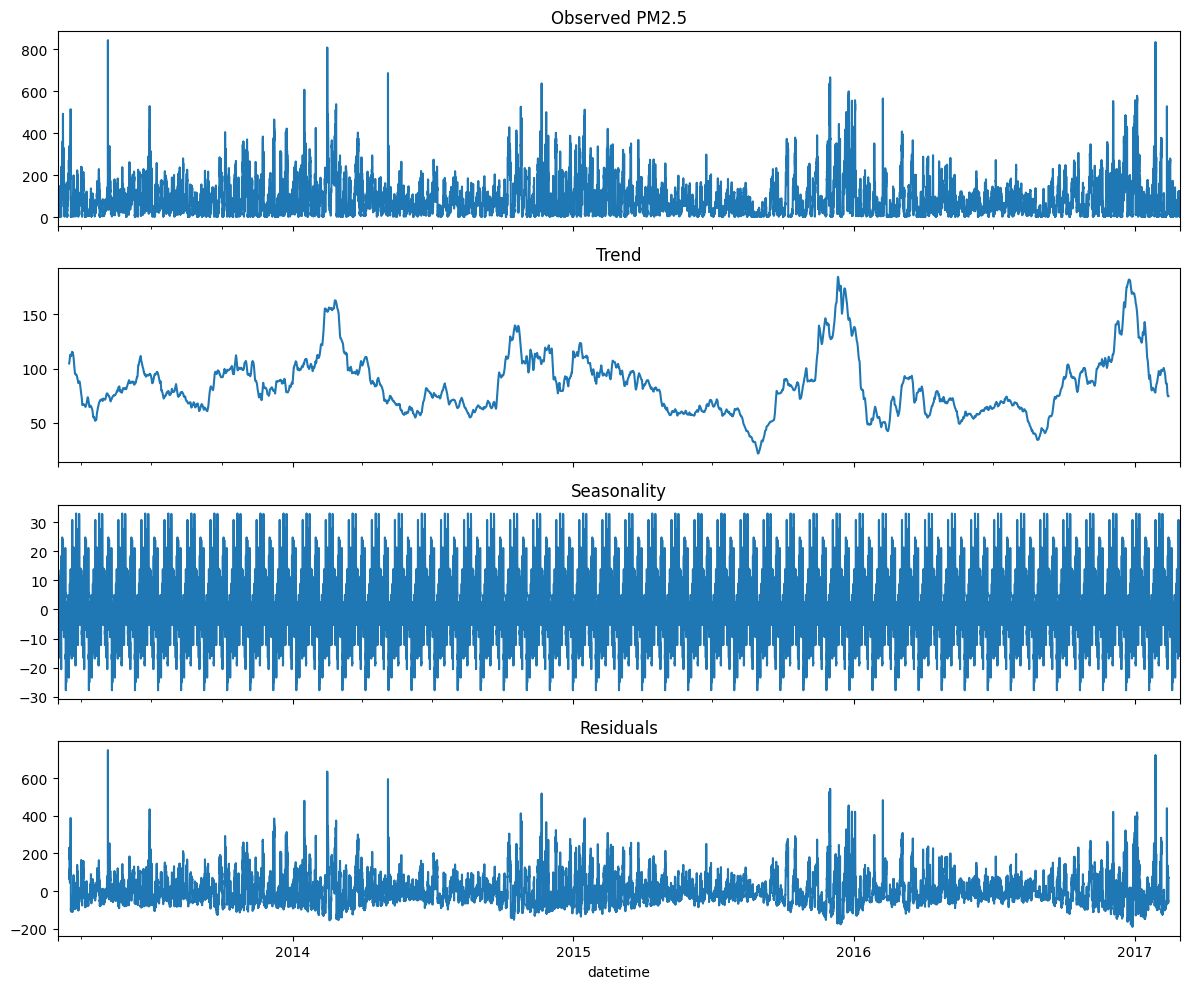

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Convert year, month, day, and hour into a datetime index
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

# Select PM2.5 for decomposition (handling missing values with interpolation)
df['PM2.5'].interpolate(inplace=True)

# Perform seasonal decomposition
decomposition = seasonal_decompose(df['PM2.5'], model='additive', period=24*30)  # Approx. monthly seasonality

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

decomposition.observed.plot(ax=axes[0], title="Observed PM2.5")
decomposition.trend.plot(ax=axes[1], title="Trend")
decomposition.seasonal.plot(ax=axes[2], title="Seasonality")
decomposition.resid.plot(ax=axes[3], title="Residuals")

plt.tight_layout()
plt.show()


### Time Series Stationarity (2 Points)

Check the Stationarity of time series using:
  * Dickey Fuller test
  * Rolling mean and Rolling standard deviation

Make the timeseries stationary

* Apply Log transformation and **Differencing** of the timeseries to make it stationary

Verify the stationarity with the Dickey Fuller test

In [ ]:
def adf_test(series):
    result = adfuller(series.dropna())  # Drop NaNs for the test
    return {
        "ADF Statistic": result[0],
        "p-value": result[1],
        "Critical Values": result[4],
        "Stationary": result[1] < 0.05  # If p-value < 0.05, the series is stationary
    }

=========================================== monthly starts  ===========================================


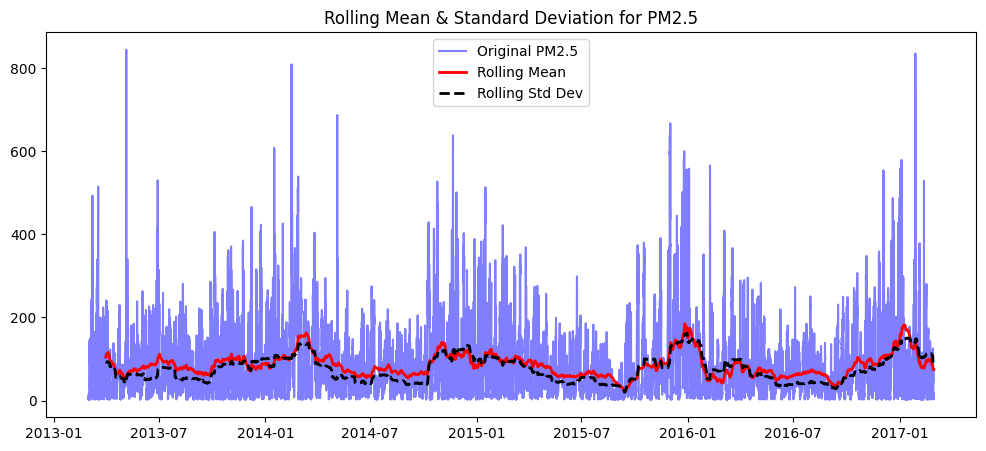

{'ADF Statistic': -19.231589413423787,
 'p-value': 0.0,
 'Critical Values': {'1%': -3.4305367654628065,
  '5%': -2.861622545720494,
  '10%': -2.566813936492474},
 'Stationary': True}

In [ ]:
import json
# YOUR CODE HERE
######### DAILY #########
# Function to perform Dickey-Fuller Test
def adf_test_for_freq(df, freq):

    period = 24*30

    rolling_mean = df['PM2.5'].rolling(window=period).mean()  # 30-day rolling mean
    rolling_std = df['PM2.5'].rolling(window=period).std()
    print('=========================================== '+freq+' starts  ===========================================')
    # Plot Original Time Series with Rolling Statistics
    plt.figure(figsize=(12, 5))
    plt.plot(df['PM2.5'], color='blue', label="Original PM2.5", alpha=0.5)
    plt.plot(rolling_mean, color='red', label="Rolling Mean", linewidth=2)
    plt.plot(rolling_std, color='black', label="Rolling Std Dev", linewidth=2, linestyle="dashed")
    plt.legend()
    plt.title("Rolling Mean & Standard Deviation for PM2.5")
    plt.show()


adf_test_for_freq(df, 'monthly')
adf_test(df['PM2.5'])

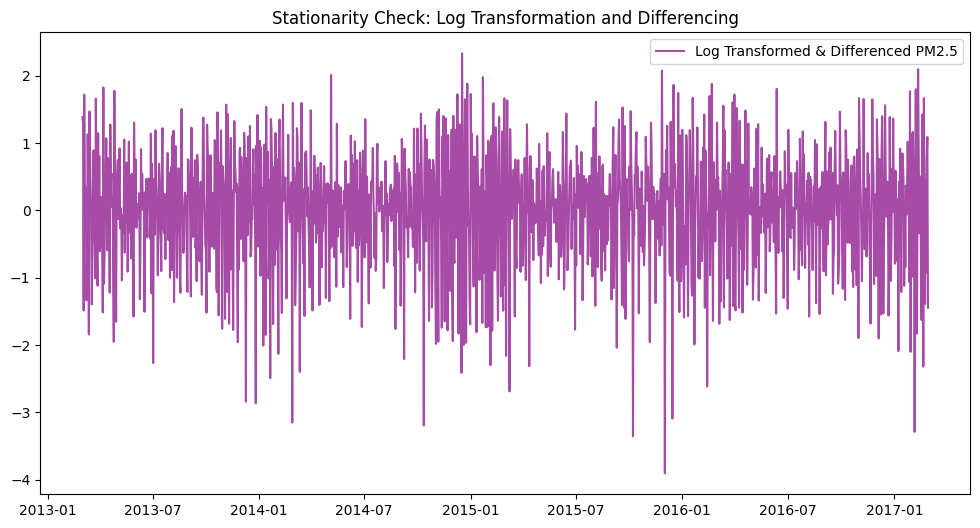

{'ADF Statistic': -13.536015983901283,
 'p-value': 2.5668363194404063e-25,
 'Critical Values': {'1%': -3.434908816804013,
  '5%': -2.863553406963303,
  '10%': -2.5678419239852994},
 'Stationary': True}

In [ ]:
# Reduce dataset size by resampling to daily mean values to avoid memory issues
df_daily = df['PM2.5'].resample('D').mean()

# Apply log transformation to stabilize variance
df_log = np.log(df_daily + 1)  # Adding 1 to avoid log(0)

# Apply differencing to remove trends
df_diff = df_log.diff().dropna()

# Plot transformed series
plt.figure(figsize=(12, 6))
plt.plot(df_diff, label="Log Transformed & Differenced PM2.5", color='purple', alpha=0.7)
plt.title("Stationarity Check: Log Transformation and Differencing")
plt.legend()
plt.show()

# Perform Dickey-Fuller test on transformed series
adf_test(df_diff)

### Auto Correlation Plot Analysis ( 2 Points)

Autocorrelation refers to the degree of correlation between the values of the same variables across different observations in the data.  The concept of autocorrelation is most often discussed in the context of time series data in which observations occur at different points in time (e.g.,temperature measured on different days of the month, hours of the day).  For example, one might expect the air temperature on the $1^{st}$ day of the month to be more similar to the temperature on the $2^{nd}$ day compared to the $31^{st}$ day.  If the temperature values that occurred closer together in time are, in fact, more similar than the temperature values that occurred farther apart in time, the data would be autocorrelated.

Autocorrelation can cause problems in conventional analyses (such as ordinary least squares regression) that assume independence of observations.

In a regression analysis, autocorrelation of the regression residuals can also occur if the model is incorrectly specified.  For example, if you are attempting to model a simple linear relationship but the observed relationship is non-linear (i.e., it follows a curved or U-shaped function), then the residuals will be autocorrelated.

* Plot ACF and PACF graphs
* Analyse and identify the ARIMA (p, d, q) terms

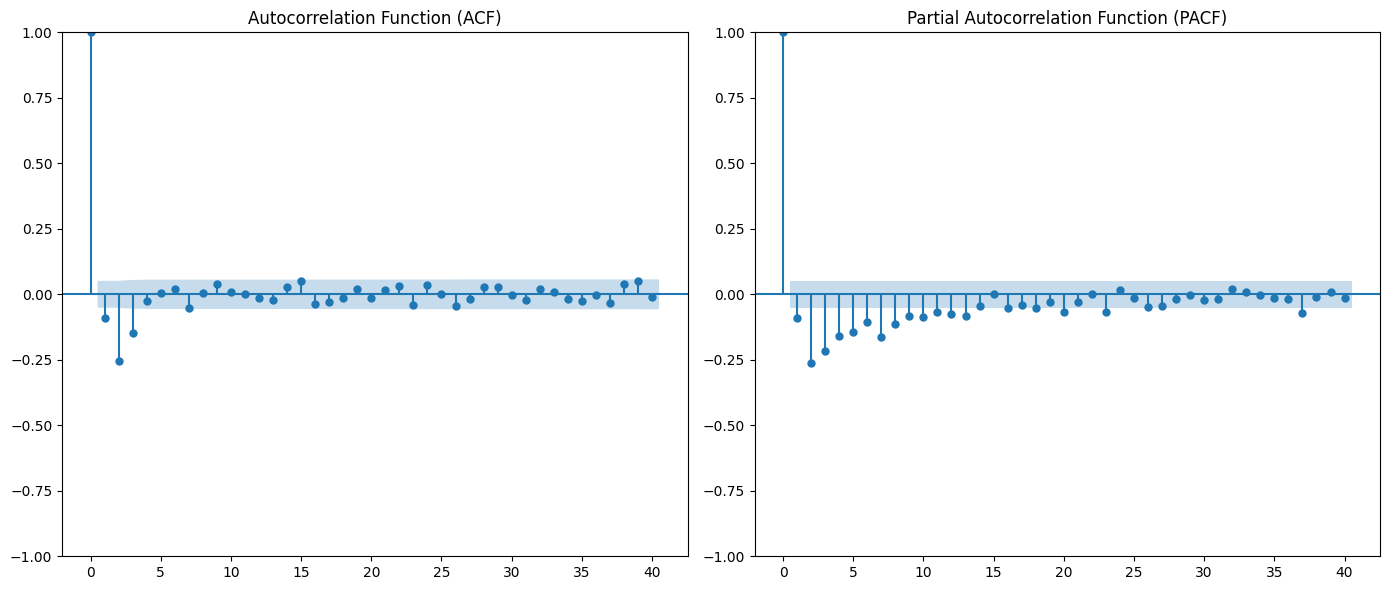

In [ ]:
# Reduce dataset size by resampling to daily mean values to avoid memory issues
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ACF plot
plot_acf(df_diff, ax=axes[0], lags=40)  # Considering 40 lags
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF plot
plot_pacf(df_diff, ax=axes[1], lags=40, method='ywm')  # Considering 40 lags
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()



###Observations:
**ACF Plot:**



*   Shows a slow decay, indicating the
*   presence of autocorrelation.
Significant lags at intervals suggest seasonality.
*   The first few lags are positive, suggesting a moving average (MA) component (q).

###PACF Plot:

*   Sharp cut-off after lag 1 or 2, suggesting an autoregressive (AR) component (p).
*   The decay pattern suggests a combination of AR and MA components.

### Implement ARIMA model (2 Points)

* Fit the timeseries data with ARIMA
* Find and interpret the loss (AIC)

In [ ]:
# YOUR CODE HERE for ARIMA Model
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (starting with ARIMA(1,1,1))
arima_model = ARIMA(df_log, order=(1, 1, 1))
arima_result = arima_model.fit()

# Print model summary
arima_summary = arima_result.summary()
arima_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  PM2.5   No. Observations:                 1461
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1651.243
Date:                Fri, 14 Mar 2025   AIC                           3308.487
Time:                        12:36:26   BIC                           3324.345
Sample:                    03-01-2013   HQIC                          3314.403
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5292      0.023     22.728      0.000       0.484       0.575
ma.L1         -0.9964      0.003   -395.160      0.000      -1.001      -0.991
sigma2         0.5608      0.020     27.716      0.000       0.521       0.600
===================================================================================
Ljung-Box (L1) (Q):                  15.19   Jarque-Bera (JB):               100.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.62
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (starting with ARIMA(1,1,1))
arima_model = ARIMA(df_log, order=(2, 1, 2))
arima_result = arima_model.fit()

# Print model summary
arima_summary = arima_result.summary()
arima_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  PM2.5   No. Observations:                 1461
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1623.738
Date:                Fri, 14 Mar 2025   AIC                           3257.476
Time:                        12:36:44   BIC                           3283.907
Sample:                    03-01-2013   HQIC                          3267.336
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6073      0.130      4.669      0.000       0.352       0.862
ar.L2         -0.1861      0.071     -2.637      0.008      -0.324      -0.048
ma.L1         -0.9724      0.131     -7.446      0.000      -1.228      -0.716
ma.L2         -0.0183      0.130     -0.141      0.888      -0.273       0.236
sigma2         0.5402      0.019     27.810      0.000       0.502       0.578
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                76.46
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.54
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Plot the predictions

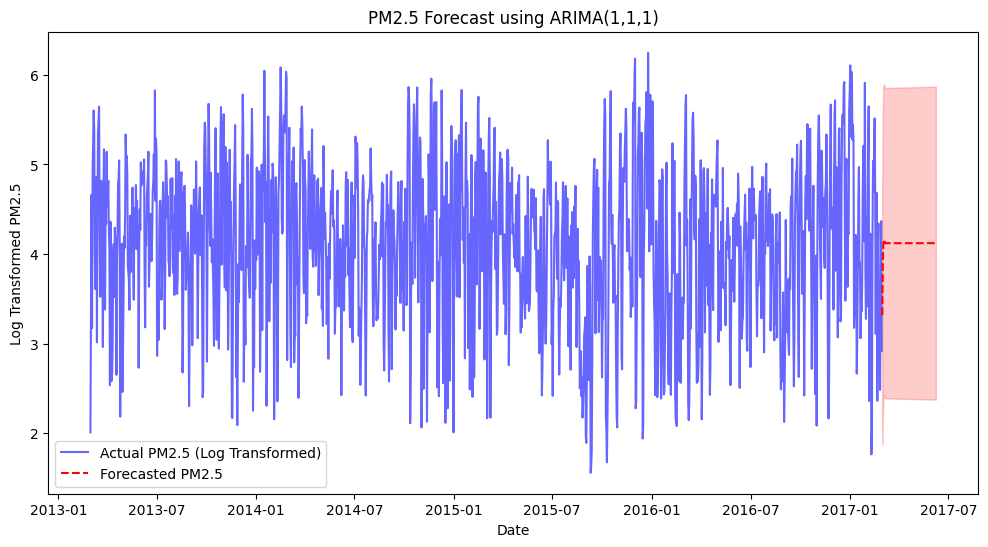

In [ ]:
# YOUR CODE HERE
# Forecasting using the ARIMA model
forecast_steps = 100  # Predict the next 100 days
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df_log.index[-1], periods=forecast_steps + 1, freq='D')[1:]

# Confidence intervals
forecast_ci = forecast.conf_int()

# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df_log, label="Actual PM2.5 (Log Transformed)", color='blue', alpha=0.6)
plt.plot(forecast_index, forecast.predicted_mean, label="Forecasted PM2.5", color='red', linestyle='dashed')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.2)
plt.title("PM2.5 Forecast using ARIMA(1,1,1)")
plt.xlabel("Date")
plt.ylabel("Log Transformed PM2.5")
plt.legend()
plt.show()

### Implement SARIMAX model (optional)

A SARIMA model can be tuned with two kinds of orders: (p,d,q) order, which refers to the order of the time series. This order is also used in the ARIMA model (which does not consider seasonality); (P,D,Q,S) seasonal order, which refers to the order of the seasonal component of the time series.

$\color{blue}{\text{Note: Implementing SARIMAX in Colab may crash the session as it may run out of RAM.}}$


$\color{blue}{\text{Alternatively you could use (free) AWS Sagemaker StudioLab. Refer to AWS Sagemaker StudioLab introductory video }}$

$$\href{https://drive.google.com/file/d/13cEzQvTzngnF8ytmHEKxUtBk72d_PqQN/view?usp=drive_link}{Click Here}$$


In [ ]:
# Fit the SARIMA model
# YOUR CODE HERE

#### Plot the predictions

In [ ]:
# predicting with SARIMA
# YOUR CODE HERE

### Report Analysis

* Comment on the trend and seasonality of the time series data
* Comment on results of the Dickey Fuller test analysis
* Is the air quality becoming poorer across the years?
* Do we see spikes indicating poor air quality in particular periods each year? What could be the reasons?

For related reading, refer to: [Time Series Analysis of PM 2.5 in Beijing](https://ionides.github.io/531w20/midterm_project/project11/midterm-project.html)